In [1]:
#TODO - analisar se o Ytest que chega aqui e o Ytest que esta no data score estao corretos

# se ele nao acha o produto ele coloca como zero.
# eu preciso receber um certo conjunto de valores, colocar um padding e pronto.

# ALTERNATIVA AQUI  - treinar a rede so nos pontos que tem visita.




# Historico
- Rede dupla e/ou com 100 neuronios: ruim. Nos primeiros passos o resultado fica razoavel, mas quando avanca piora.
- Rede unica com 10 neuronios: bom.

In [1]:
#https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
import sys 
import json
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph 
import math
import collections
import pandas as pd

## for Deep-learing:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.models import model_from_json
from tensorflow.python.keras.callbacks import TensorBoard

from itertools import product
from functools import partial
from time import time

from core.DataExploration import DataExploration
from core.ModelIndicators import ModelIndicators
from ruptura.CreateBatch import CreateBatch
from ruptura.RupturaPrediction import RupturaPrediction
from ruptura.RupturaNeuralNetwork import RupturaNeuralNetwork
from ruptura.CalculateScore import CalculateScore

def defineLossWeights(yUnknow):
    weigths = []
    for y in yUnknow:
        if y == 0:
            weigths.append(1)
        else:
            weigths.append(0.1)
    return weigths


Using TensorFlow backend.


In [2]:
version = '0-1-0'
referenceDate = '1/03/2019'
modelName = 'model-' + version

# CARREGAMENTO DOS DADOS

In [3]:
createBatch = CreateBatch(version)
X, Y, Ytest, lastX = createBatch.batch('barbieri-ymod.json') # Tem que resolver esse warning
xUnknow, yUnknow = createBatch.getUnknwows()
titles = createBatch.titles

# MODEL DEFINITION

In [4]:
batch_size = 64
weightVector = defineLossWeights(yUnknow)
time_steps = X.shape[1]
x_dimension = X.shape[2]
y_dimension = Y.shape[2]
if len(weightVector) != y_dimension:
    raise Exception('custom loss weights is not defined correctly')

rupNN = RupturaNeuralNetwork(modelName)
newModel = False

if newModel:
    n_neurons = 12
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    model.add(TimeDistributed(Dense(y_dimension, activation='softmax')))
    #model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    #model.add(TimeDistributed(Dense(x_dimension, activation='softmax')))
    model.compile(
        loss=rupNN.getCustomLoss((batch_size,time_steps), weightVector),
        optimizer='adam')
    print('MODEL CREATED\n')
    print(model.summary())
else:
    model = rupNN.loadModel((batch_size,time_steps), weightVector)  # Y dimensions are needed for custom loss definitions
    print('MODEL LOADED\n')
    print(model.summary())

MODEL LOADED

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 12)            768       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 2)             26        
Total params: 794
Trainable params: 794
Non-trainable params: 0
_________________________________________________________________
None


# TRAINING

In [ ]:
cut1 = batch_size
cut2 = X.shape[0] - X.shape[0]%batch_size
Xval, Xtrain,_ = np.split(X,[cut1,cut2])
Yval, Ytrain,_ = np.split(Y,[cut1,cut2])
for step in range(30):
    n_epoch = 100
    model.fit(Xtrain, 
              Ytrain, 
              epochs=n_epoch, 
              batch_size= batch_size, 
              validation_data=(Xval, Yval),
              verbose=2)
    rupNN.saveModel(model)

# VALIDATION - ANTIGA

In [5]:
#rupPred = RupturaPrediction(X)
#rupPred.DESCONHECIDO = xUnknow
#rupPred.addLastX(lastX)
#rupPred.validate(Ytest, model)
#dataScore = rupPred.calculateDataScore()  # passo que define a validacao
#rupPred.plotScore(dataScore)  # calculate score precisa ser um objeto separado

essa funcao depende muito do formato do Y


In [ ]:
#xnext = []
#for xBatch, point in zip(X, lastX):
#    #print(point)
#    print(point.shape)
#    xnext.append(np.append(xBatch,[point],axis=0))

In [ ]:
#pred = dataScore.score.tolist()
#ytrue = dataScore.Inadimplente.tolist()
#ytrue = [int(x) for x in ytrue]
#modelIndicators = ModelIndicators(version)
#modelIndicators.TARGET_SCORE_CUT = 30
#modelIndicators.setPredProbs(ytrue,pred)
#indic = modelIndicators.allIndicators()
#file = open('ruptura-indicators.csv','a+')
#file.write('\n' + 'version;' + version + ';' + 'referenceDate;' + referenceDate + '\n')
#for i in range(len(indic)):
#    file.write(str(indic.index[i]) + ';' + str(indic.iloc[i,0]) + '\n')
#file.close()

# NOVA VALIDACAO

In [5]:
rupPred = RupturaPrediction(X, xUnknow)
dayBatch = rupPred.returnSelectedDayBatch(X, -1)
annPredictions = rupPred.walkNSteps(model, 7)
calculateScore = CalculateScore('0-1-0')
score = calculateScore.calculate(annPredictions)
scoreY = calculateScore.calculate(Ytest)

# OBTEM A PRIMEIRA VISITA DE CADA LOJA

In [6]:
stores = {}
for i_batch, clientProd in enumerate(titles):
    store, _ = clientProd.split('-')
    if store in stores:
        stores[store]['iBatch'].append(i_batch)
    else:
        stores[store] = {}
        stores[store]['iBatch'] = [i_batch]
for store in stores:
    for day in range(Ytest.shape[1]):
        visitFound = False
        for i_batch in stores[store]['iBatch']:
            if Ytest[i_batch][day][1] != 1:
                stores[store]['visitDay'] = day
                visitFound = True
                break
        if visitFound:
            break
    if not visitFound:
        stores[store]['visitDay'] = -1    

#allVist = []  - contagem das visitas
#for store in stores:
#    allVist.append(stores[store]['visitDay'])
#collections.Counter(allVist)

# COMPARACAO ENTRE A VISITA E O QUE A REDE NEURAL PREVIU

In [18]:
scoreVisit = {}
for store in stores:
    visitDay = stores[store]['visitDay']
    if visitDay == -1:
        continue
    else:
        #print(stores[store]['visitDay'])
        #print(stores[store]['iBatch'])
        scoreVisit[store] = {}
        scoreVisit[store]['real'] = []
        scoreVisit[store]['predicted'] = []
        for i_batch in stores[store]['iBatch']:
            scoreVisit[store]['real'].append(scoreY[i_batch][visitDay])
            scoreVisit[store]['predicted'].append(score[i_batch][visitDay])


In [41]:
scoreReal = []
scorePred = []
nProdutos = []
for store in scoreVisit:
    nProdutos.append(len(scoreVisit[store]['real']))
    scoreReal.append(np.mean(scoreVisit[store]['real']))
    scorePred.append(np.mean(scoreVisit[store]['predicted']))
df = pd.DataFrame(scoreReal)
df['scorePred'] = scorePred
df['nprod'] = nProdutos
df.index = list(scoreVisit.keys())
df.columns = ['scoreReal', 'scorePred','nprod']

In [29]:
import matplotlib.pyplot as plt

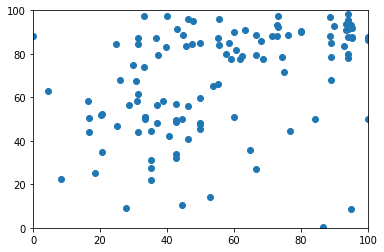

In [38]:
plt.ylim(0,100)
plt.xlim(0,100)
plt.scatter(df.iloc[:,0],df.iloc[:,1])

In [42]:
df.to_csv('scores-visitas.csv',sep=';')

In [49]:
for i in stores['BH S O GON ALO SAPUCA LOJA 196']['iBatch']:
    print(titles[i])

BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI ESCALDADO 150G
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI PAPA OVO 150G
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI POLVILHO ARGOLA TRADICIONAL 150G
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI POLVILHO PALITO SABOR QUEIJO 150G
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI POLVILHO PALITO TRADICIONAL 150G
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI SEQUILHOS LEITE 500G
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI SEQUILHOS TRADICIONAL 500G
BH S O GON ALO SAPUCA LOJA 196-SUSPIRO BARBIERI TRADICIONAL 250G
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI ESCALDADO 150G CI 127810
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI PAPA OVO 150G CI 147543
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI POLVILHO ARGOLA QUEIJO 150G CI 147541
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI POLVILHO ARGOLA TRADICIONAL 150G CI 147540
BH S O GON ALO SAPUCA LOJA 196-BISCOITO BARBIERI POLVILHO PALITO SABOR QUEIJO 150G CI 147

In [50]:
titles[9]

'ABC Av Sen Montandon Arax LOJA 16-BISCOITO BARBIERI ESCALDADO 150G'

In [ ]:

    
##############################################################################################
# SCORE
##############################################################################################

    def plotScore(self, dataScore):
        dataScore.loc[:,'Inadimplente'] = [str(x) for x in dataScore.loc[:,'Inadimplente'].values]
        de = DataExploration(dataScore)
        de.setNpoints(self.PLOT_POINTS)
        de.graphicInadimplenciaXContinuum(dataScore, 'score')

    def plotAllBatches(self):
        for i_batch in range(self.__score.shape[1]):
            self.plotSampleOfBatch(i_batch)
    
    def plotSampleOfBatch(self, i_batch): #need to validate first
        if self.__walkCounter == 0:
            raise Exception('Cant plot sample, need to validate first')
        pred = self.__score[:,i_batch]
        real = self.__realValues[:,i_batch]
        x = range(len(pred))
        fig = plt.figure()
        name = 'amostra-' + str(i_batch) + '-previsto-vs-real'
        plt.title(name)
        plt.ylim((-0.1, 1.1))  
        plt.plot(x, pred, 'r', label='PREVISTO, x') # x
        plt.plot(x, real, 'b', label='REAL, y') # y
        plt.legend(loc='best')
        fig.savefig(name + '.png',dpi=150)
        plt.close(fig)
     
    
    
##############################################################################################
# VALIDATION
##############################################################################################
 
    def validate(self,Ytest, model):
        for i in range(self.VALIDATION_DAYS):
            self.step(model)
            self.__realValues.append(self.calculateScoreOfBatch(Ytest,i))
        self.__realValues = np.array(self.__realValues)
        self.__score = np.array(self.__score)
    
    def calculateDataScore(self):
        print('essa funcao depende muito do formato do Y')
        dataScore = []
        for i_batch in range(self.__realValues.shape[1]):
            predictions = []
            for day in range(self.__realValues.shape[0]):
                predictions.append(self.__score[day][i_batch])
                if self.__realValues[day][i_batch] != -1:
                    rupScore = int(100*np.max(predictions))
                    dataScore.append((rupScore,self.__realValues[day][i_batch]))
                    break
        dataScore = pd.DataFrame(data=dataScore,columns=['score','Inadimplente'])
        return dataScore
    
    def calculateScoreOfBatch(self, pointsBatch, time_step = -1):
        points = self.getStepPoints(pointsBatch, time_step)
        score = []
        for point in points:
            if point[1] == 1:
                score.append(-1)
            else:
                score.append(point[0])
        return score





# ESTATISTICA DESCRITIVA

In [ ]:
allT = [x.split('-') for x in createBatch.titles]
loja = []
prod = []
for t in allT:
    loja.append(t[0])
    prod.append(t[1])
nPontosDeVenda = len(collections.Counter(loja).keys())
nProdutos = len(collections.Counter(prod).keys())
xzao = []
for x in X:
    for xt in x:
        xzao.append(str(xt))
ocorrenciaCounter = collections.Counter(xzao)        